### Fade Margin (FM) Section — Calibrate on OOF, Validate on Test

This notebook calibrates fade margins (FM) for multiple model families (BLR, MLR, POLY2) using Out-Of-Fold (OOF) residuals and validates them on the held-out test residuals.

#### Core & Data Libraries

In [5]:
# SPEED HEADER
import os
# Stop BLAS from oversubscribing; we parallelize with joblib instead
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Joblib process temp in RAM if available (faster on Linux)
if os.path.isdir("/dev/shm"):
    os.environ.setdefault("JOBLIB_TEMP_FOLDER", "/dev/shm/joblib")

# Parallelism knob for bootstraps 
N_JOBS = 18

# Core & Data Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

#  ML & Stats 
from sklearn.mixture import GaussianMixture
import scipy.stats as sps  # use SciPy if present

#  Parallel 
from joblib import Parallel, delayed

#  Global Toggles 
# Reproducibility / method toggles
EXACT_BCA        = False   # True => exact BCa (jackknife; slower). False => fast BC (no jackknife).
BLOCK_BY_DEVICE  = True    # MBB applied within each device cluster

RANDOM_STATE     = 42

# Targets and baseline
P_GRID           = [0.05, 0.02, 0.01]   # p in {5%, 2%, 1%}
HEURISTIC_FM_DB  = 10.0                 # baseline for comparison

#### Load OOF Residuals

In [7]:
# Data locations
OOF_DIR  = "../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF"
TEST_DIR = "../Extended Parametric Regression Files+Plots/Reports/Residuals_Test"

# Candidate mappings (OOF) 
CANDIDATE_OOF_FILES = {
    "BLR":   [f"{OOF_DIR}/residuals__BLR__BEST__oof.csv",   f"{OOF_DIR}/residuals_BLR_BEST_oof.csv"],
    "MLR":   [f"{OOF_DIR}/residuals__MLR__BEST__oof.csv",   f"{OOF_DIR}/residuals_MLR_BEST_oof.csv"],
    "POLY2": [f"{OOF_DIR}/residuals__POLY2__BEST__oof.csv", f"{OOF_DIR}/residuals_POLY2_BEST_oof.csv"],
}

# Column detection candidates
TIME_COL_CANDS   = ["timestamp","ts","time","datetime","DateTime","TIME"]
DEVICE_COL_CANDS = ["device","Device","ed","ED","node","Node"]
RESID_COL_CANDS  = ["resid_db", "residuals", "resid", "error", "epsilon"]

def _first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("None of the candidate paths exist:\n  " + "\n  ".join(paths))

def _pick_residual_col(df):
    for c in RESID_COL_CANDS:
        if c in df.columns:
            return c
    raise KeyError("Residual column not found in dataframe.")

def _find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _time_sort(df):
    tc = _find_col(df, TIME_COL_CANDS)
    if tc is None:
        return df
    # robust: try native sort; if fails, coerce to datetime
    try:
        return df.sort_values(tc)
    except Exception:
        tmp = pd.to_datetime(df[tc], errors='coerce')
        return df.assign(_t=tmp).sort_values('_t').drop(columns=['_t'])

# ---- Load OOF (train-side) and matching TEST residuals ----
oof_residuals = {}     # fam -> np.array
test_residuals = {}    # fam -> np.array
oof_devices   = {}     # fam -> device array or None
test_devices  = {}     # fam -> device array or None
model_tags    = {}     # fam -> best tag from 'model' column if present

for fam, candidates in CANDIDATE_OOF_FILES.items():
    oof_path = _first_existing(candidates)
    df_oof = _time_sort(pd.read_csv(oof_path))
    res_col = _pick_residual_col(df_oof)
    eps_oof = df_oof[res_col].astype(float).to_numpy()
    oof_residuals[fam] = eps_oof

    # capture device arrays if present
    dev_col_oof = _find_col(df_oof, DEVICE_COL_CANDS)
    oof_devices[fam] = df_oof[dev_col_oof].astype(str).to_numpy() if dev_col_oof else None

    # Prefer specific best tag if present
    specific_tag = None
    if "model" in df_oof.columns and pd.api.types.is_string_dtype(df_oof["model"]):
        try:
            specific_tag = str(df_oof["model"].iloc[0])
        except Exception:
            specific_tag = None
    model_tags[fam] = specific_tag if specific_tag else f"{fam}__BEST"

    # Resolve TEST file; try specific tag first, then family aliases
    test_candidates = []
    if specific_tag:
        test_candidates.append(f"{TEST_DIR}/residuals__{specific_tag}__test.csv")
    test_candidates += [
        f"{TEST_DIR}/residuals__{fam}__BEST__test.csv",
        f"{TEST_DIR}/residuals_{fam}_BEST_test.csv",
    ]
    test_path = _first_existing(test_candidates)
    df_test = _time_sort(pd.read_csv(test_path))
    res_col_test = _pick_residual_col(df_test)
    eps_test = df_test[res_col_test].astype(float).to_numpy()
    test_residuals[fam] = eps_test

    dev_col_test = _find_col(df_test, DEVICE_COL_CANDS)
    test_devices[fam] = df_test[dev_col_test].astype(str).to_numpy() if dev_col_test else None

    print(f"[{fam}] OOF: {oof_path} (n={len(eps_oof)}) | TEST: {test_path} (n={len(eps_test)})")

[BLR] OOF: ../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF/residuals__BLR__BEST__oof.csv (n=1341431) | TEST: ../Extended Parametric Regression Files+Plots/Reports/Residuals_Test/residuals__BLR_gprior__a0=0.01__b0=0.01__g_mode=uip__test.csv (n=335358)
[MLR] OOF: ../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF/residuals__MLR__BEST__oof.csv (n=1341431) | TEST: ../Extended Parametric Regression Files+Plots/Reports/Residuals_Test/residuals__MLR_Ridge__alpha=3.1622776601683795__test.csv (n=335358)
[POLY2] OOF: ../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF/residuals__POLY2__BEST__oof.csv (n=1415913) | TEST: ../Extended Parametric Regression Files+Plots/Reports/Residuals_Test/residuals__POLY2_Ridge__alpha=1.0__test.csv (n=353979)


#### FM Calibration Utilities

In [9]:
def acf(x, max_lag=None):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    if n < 3:
        max_lag = 1
    if max_lag is None:
        max_lag = min(200, n - 2) if n > 2 else 1
    c = np.correlate(x, x, mode='full')[n-1:n+max_lag]
    if c[0] == 0:
        return np.arange(max_lag+1), np.ones(max_lag+1)
    return np.arange(max_lag+1), c / c[0]

def choose_block_len_acf(x, alpha=0.05, max_lag=None):
    lags, ac = acf(x, max_lag=max_lag)
    n = len(x)
    if n < 50:
        return 0, {"note": "sample too small; using i.i.d."}
    thr = 1.96 / np.sqrt(n)  # ~95% bounds
    idx = np.where(np.abs(ac[1:]) < thr)[0]
    if len(idx) == 0:
        k = min(len(ac)-1, 25)
    else:
        k = int(idx[0] + 1)
    b = max(5, k)
    return b, {"thr": thr, "first_below_thr_lag": k}

def choose_block_len_acf_cluster(x, clust):
    """Median block length across clusters (skip very small ones)."""
    x = np.asarray(x)
    clust = np.asarray(clust) if clust is not None else None
    if clust is None:
        b, _ = choose_block_len_acf(x)
        return b
    b_list = []
    for g in np.unique(clust):
        idx = (clust == g)
        if idx.sum() < 50:  # insufficient for ACF estimate
            continue
        b_g, _ = choose_block_len_acf(x[idx])
        b_list.append(b_g)
    if not b_list:
        return 0
    return int(np.median(b_list))

def _mbb_draw(x, n, b, rng):
    """Moving-block bootstrap draw of length n from series x with block size b."""
    x = np.asarray(x)
    if b <= 1 or b >= len(x):
        return x[rng.integers(0, len(x), size=n)]
    k = int(np.ceil(n / b))
    starts = rng.integers(0, len(x) - b + 1, size=k)
    return np.concatenate([x[s:s+b] for s in starts])[:n]

def _mbb_draw_by_cluster(x, clust, b, rng):
    """MBB within device clusters; preserves per-device lengths."""
    x = np.asarray(x)
    clust = np.asarray(clust)
    out = []
    for g in np.unique(clust):
        idx = np.where(clust == g)[0]
        xx = x[idx]
        n_g = len(xx)
        out.append(_mbb_draw(xx, n_g, b, rng))
    return np.concatenate(out)

def normal_cdf(z):
    z = np.asarray(z, dtype=float)
    return sps.norm.cdf(z)

def empirical_quantile(sample, p):
    # FM(p) = Q_{1-p} of residuals
    return float(np.quantile(sample, 1 - p, method='linear'))

def t_fit_quantile(sample, p):
    df, loc, scale = sps.t.fit(sample)
    q = float(sps.t.ppf(1 - p, df, loc, scale))
    logL = float(sps.t.logpdf(sample, df, loc, scale).sum())
    k = 3; n = len(sample)
    aic = 2*k - 2*logL
    bic = k*np.log(n) - 2*logL
    return q, (df, loc, scale), aic, bic

def mixture_quantile(weights, means, stds, q, tol=1e-6, max_iter=256):
    means = np.asarray(means); stds = np.asarray(stds)
    stds = np.maximum(stds, 1e-6)  # guard against numeric degeneracy
    lo = float(means.min() - 10*stds.max())
    hi = float(means.max() + 10*stds.max())
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        F = float(np.sum(weights * normal_cdf((mid - means)/stds)))
        if F < q: lo = mid
        else:     hi = mid
        if hi - lo < tol: break
    return 0.5*(lo+hi)

def gmm_fit_quantile(sample, p, max_k=3):
    xs = sample.reshape(-1,1)
    best = None
    for k in range(1, max_k+1):
        gmm_m = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE)
        gmm_m.fit(xs)
        bic = gmm_m.bic(xs); aic = gmm_m.aic(xs)
        if (best is None) or (bic < best["bic"]):
            best = {"gmm": gmm_m, "k": k, "bic": float(bic), "aic": float(aic)}
    w = best["gmm"].weights_
    mu = best["gmm"].means_.ravel()
    cov = best["gmm"].covariances_
    stds = np.sqrt(cov.reshape(-1)) if cov.ndim == 3 else np.sqrt(cov)
    q = mixture_quantile(w, mu, stds, 1 - p)
    return float(q), best, best["aic"], best["bic"]

# ===== CIs =====

def bca_ci(x, stat_fn, alpha=0.05, B=10_000, block_len=0, rng=None, cluster=None):
    """
    Exact BCa CI for statistic stat_fn over sample x.
    Uses MBB if block_len>0; device-aware if cluster provided and BLOCK_BY_DEVICE=True.
    """
    rng = np.random.default_rng(RANDOM_STATE if rng is None else rng)
    x = np.asarray(x)
    n = len(x)
    theta_hat = stat_fn(x)

    # bootstrap replicates (parallel not used here to keep jackknife weights coherent)
    thetas = np.empty(B, dtype=float)
    ss = np.random.SeedSequence(RANDOM_STATE)
    children = ss.spawn(B)
    for b in range(B):
        rr = np.random.default_rng(children[b])
        if block_len > 1:
            if (cluster is not None) and BLOCK_BY_DEVICE:
                xb = _mbb_draw_by_cluster(x, cluster, block_len, rr)
            else:
                xb = _mbb_draw(x, n, block_len, rr)
        else:
            xb = x[rr.integers(0, n, size=n)]
        thetas[b] = stat_fn(xb)
    thetas.sort()

    # bias-correction z0
    z0 = sps.norm.ppf((thetas < theta_hat).mean() + 1e-12)

    # jackknife for acceleration 'a'
    jack = np.empty(n)
    for i in range(n):
        jack[i] = stat_fn(np.delete(x, i))
    jack_mean = jack.mean()
    num = np.sum((jack_mean - jack)**3)
    den = 6.0 * (np.sum((jack_mean - jack)**2) ** 1.5)
    a = (num / den) if den > 0 else 0.0

    zal = sps.norm.ppf(alpha/2); zau = sps.norm.ppf(1 - alpha/2)
    def _adj(z): return sps.norm.cdf(z0 + (z0 + z) / (1 - a*(z0 + z)))
    a1 = float(np.clip(_adj(zal), 0, 1)); a2 = float(np.clip(_adj(zau), 0, 1))

    lo = float(np.quantile(thetas, a1, method='linear'))
    hi = float(np.quantile(thetas, a2, method='linear'))
    return lo, hi, {"theta_hat": float(theta_hat), "z0": float(z0), "a": float(a)}

def _boot_q_once(x, p, b, sseq, cluster=None):
    rr = np.random.default_rng(sseq)
    if b > 1:
        if (cluster is not None) and BLOCK_BY_DEVICE:
            xb = _mbb_draw_by_cluster(x, cluster, b, rr)
        else:
            xb = _mbb_draw(x, len(x), b, rr)
    else:
        xb = x[rr.integers(0, len(x), size=len(x))]
    return float(np.quantile(xb, 1 - p, method='linear'))

def bc_ci_fast(x, p, alpha=0.05, B=3000, block_len=0, n_jobs=N_JOBS, seed=RANDOM_STATE, cluster=None):
    """
    Fast CI for FM(p)=Q_{1-p}:
    - Parallel bootstrap with MBB (b>0); device-aware if cluster provided.
    - Bias-Corrected (BC) via z0 (no jackknife).
    """
    x = np.asarray(x, float)
    theta_hat = float(np.quantile(x, 1 - p, method='linear'))

    ss = np.random.SeedSequence(seed)
    children = ss.spawn(B)

    q_boot = Parallel(n_jobs=n_jobs, backend="loky", max_nbytes="256M", verbose=0)(
        delayed(_boot_q_once)(x, p, block_len, child, cluster) for child in children
    )
    q_boot = np.asarray(q_boot, float)

    if q_boot.min() < theta_hat < q_boot.max():
        prop = (q_boot < theta_hat).mean()
        z0 = float(sps.norm.ppf(min(max(prop, 1e-12), 1 - 1e-12)))
        al = float(sps.norm.cdf(2*z0 + sps.norm.ppf(alpha/2)))
        au = float(sps.norm.cdf(2*z0 + sps.norm.ppf(1 - alpha/2)))
        al = float(np.clip(al, 0.0, 1.0)); au = float(np.clip(au, 0.0, 1.0))
    else:
        al, au = alpha/2, 1 - alpha/2

    lo, hi = np.quantile(q_boot, [al, au], method='linear')
    return float(lo), float(hi), {"theta_hat": theta_hat}

def fm_with_uncertainty(eps, p, use_parametric=True, B=5000, random_state=RANDOM_STATE, cluster=None):
    eps = np.asarray(eps, float)

    # Dependence-aware block length (per cluster if available)
    block_len = choose_block_len_acf_cluster(eps, cluster)

    # Empirical quantile + CI
    if EXACT_BCA:
        lo_e, hi_e, info = bca_ci(
            eps,
            stat_fn=lambda v: float(np.quantile(v, 1 - p, method='linear')),
            alpha=0.05, B=B, block_len=block_len, rng=random_state, cluster=cluster
        )
        fm_emp = float(np.quantile(eps, 1 - p, method='linear'))
        note = "empirical quantile (BCa)"
    else:
        lo_e, hi_e, info = bc_ci_fast(
            eps, p, alpha=0.05, B=B, block_len=block_len, n_jobs=N_JOBS, seed=random_state, cluster=cluster
        )
        fm_emp = info["theta_hat"]
        note = "empirical quantile (BC bootstrap)"

    out = {
        "p": p, "block_len": block_len,
        "fm_emp": fm_emp, "fm_emp_lo": lo_e, "fm_emp_hi": hi_e,
        "selected": "empirical", "fm_sel": fm_emp, "fm_sel_lo": lo_e, "fm_sel_hi": hi_e,
        "estimator_note": note
    }

    # Parametric tail — point estimate only; choosen by BIC
    if use_parametric:
        fm_t, t_params, aic_t, bic_t = t_fit_quantile(eps, p)
        fm_g, gmm_best, aic_g, bic_g = gmm_fit_quantile(eps, p)
        cand = []
        if np.isfinite(bic_t): cand.append(("t", fm_t, aic_t, bic_t))
        if gmm_best is not None: cand.append(("gmm", fm_g, aic_g, bic_g))
        if cand:
            sel_name, fm_par, aic_sel, bic_sel = min(cand, key=lambda z: z[3])
            out.update({"param_name": sel_name, "fm_param": fm_par,
                        "fm_param_lo": np.nan, "fm_param_hi": np.nan,
                        "param_bic": float(bic_sel), "param_aic": float(aic_sel)})
            # Conservative switch at far tail if parametric is larger
            if p <= 0.02 and (fm_par > fm_emp):
                out.update({"selected": f"{sel_name}-tail",
                            "fm_sel": fm_par, "fm_sel_lo": lo_e, "fm_sel_hi": hi_e,
                            "estimator_note": f"{sel_name} tail (BIC-min)"})
    return out

#### Calibrate on OOF + Load Test Residuals

In [11]:
rows = []
for fam, eps in oof_residuals.items():
    for p in P_GRID:
        out = fm_with_uncertainty(eps, p, use_parametric=True, B=5000,
                                  random_state=RANDOM_STATE, cluster=oof_devices.get(fam))
        rows.append({"model": fam, **out})

fm_table = pd.DataFrame(rows)
display_cols = ["model", "p", "fm_emp", "fm_emp_lo", "fm_emp_hi",
                "param_name", "fm_param",
                "selected", "fm_sel", "fm_sel_lo", "fm_sel_hi", "block_len", "estimator_note"]

display(fm_table[display_cols].round(3).sort_values(["model","p"]))

,model,p,fm_emp,fm_emp_lo,fm_emp_hi,param_name,fm_param,selected,fm_sel,fm_sel_lo,fm_sel_hi,block_len,estimator_note
2,BLR,0.01,27.744,27.353,28.140,gmm,27.730,empirical,27.744,27.353,28.140,25,empirical quantile (BC bootstrap)
1,BLR,0.02,19.398,19.274,19.535,gmm,21.636,gmm-tail,21.636,19.274,19.535,25,gmm tail (BIC-min)
0,BLR,0.05,12.875,12.813,12.940,gmm,12.752,empirical,12.875,12.813,12.940,25,empirical quantile (BC bootstrap)
5,MLR,0.01,27.744,27.353,28.140,gmm,27.907,gmm-tail,27.907,27.353,28.140,25,gmm tail (BIC-min)
4,MLR,0.02,19.398,19.274,19.535,gmm,21.486,gmm-tail,21.486,19.274,19.535,25,gmm tail (BIC-min)
3,MLR,0.05,12.875,12.813,12.940,gmm,12.597,empirical,12.875,12.813,12.940,25,empirical quantile (BC bootstrap)
8,POLY2,0.01,24.487,24.302,24.656,gmm,25.726,gmm-tail,25.726,24.302,24.656,25,gmm tail (BIC-min)
7,POLY2,0.02,18.287,18.170,18.409,gmm,19.715,gmm-tail,19.715,18.170,18.409,25,gmm tail (BIC-min)
6,POLY2,0.05,11.707,11.634,11.783,gmm,11.119,empirical,11.707,11.634,11.783,25,empirical quantile (BC bootstrap)


#### Held‑Out Validation (Test) for all three models

In [13]:
def achieved_outage_rate(eps_test, FM):
    return float(np.mean(eps_test > FM))

validation_rows = []
for fam, eps_test in test_residuals.items():
    sub = fm_table[fm_table["model"] == fam]
    for _, r in sub.iterrows():
        FM = r["fm_sel"]; p = r["p"]
        phat = achieved_outage_rate(eps_test, FM)
        validation_rows.append({
            "model": fam, "p_target": p,
            "FM_used": FM, "FM_lo": r["fm_sel_lo"], "FM_hi": r["fm_sel_hi"],
            "achieved_outage": phat, "achieved_PDR": 1.0 - phat,
            "estimator": r["selected"]
        })
    # Heuristic baseline
    ph = achieved_outage_rate(eps_test, HEURISTIC_FM_DB)
    validation_rows.append({
        "model": fam, "p_target": None,
        "FM_used": HEURISTIC_FM_DB, "FM_lo": np.nan, "FM_hi": np.nan,
        "achieved_outage": ph, "achieved_PDR": 1.0 - ph,
        "estimator": f"Heuristic ({HEURISTIC_FM_DB} dB)"
    })

validation_df = pd.DataFrame(validation_rows)

display(validation_df.sort_values(["model","p_target"], na_position='last').round(4))

,model,p_target,FM_used,FM_lo,FM_hi,achieved_outage,achieved_PDR,estimator
2,BLR,0.01,27.7439,27.3531,28.1402,0.0098,0.9902,empirical
1,BLR,0.02,21.6362,19.2741,19.5353,0.0154,0.9846,gmm-tail
0,BLR,0.05,12.8749,12.8129,12.9403,0.0498,0.9502,empirical
3,BLR,NaN,10.0000,NaN,NaN,0.0836,0.9164,Heuristic (10.0 dB)
6,MLR,0.01,27.9067,27.3531,28.1401,0.0097,0.9903,gmm-tail
5,MLR,0.02,21.4858,19.2741,19.5353,0.0156,0.9844,gmm-tail
4,MLR,0.05,12.8749,12.8129,12.9402,0.0498,0.9502,empirical
7,MLR,NaN,10.0000,NaN,NaN,0.0836,0.9164,Heuristic (10.0 dB)
10,POLY2,0.01,25.7259,24.3022,24.6563,0.0087,0.9913,gmm-tail
9,POLY2,0.02,19.7154,18.1705,18.4088,0.0166,0.9834,gmm-tail


#### Plot: PDR vs FM — overlay for BLR / MLR / POLY2

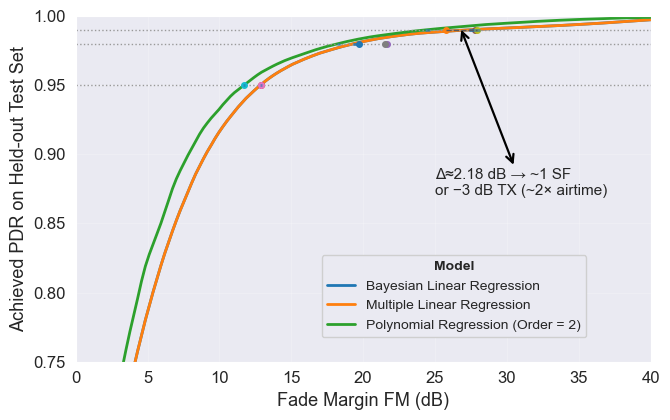

In [15]:
sns.set_style("darkgrid")

legend_map = {
    "MLR":  "Multiple Linear Regression",
    "BLR":  "Bayesian Linear Regression",
    "POLY2":"Polynomial Regression (Order = 2)",
}

def pdr_curve(eps_test, fm_min=0.0, fm_max=None, num=160):
    if fm_max is None:
        fm_max = max(HEURISTIC_FM_DB, np.percentile(eps_test, 99.9))
    grid = np.linspace(fm_min, fm_max, num=num)
    pdr = np.array([np.mean(eps_test <= m) for m in grid], float)
    return grid, pdr

# Shared x-range
eps_all = list(test_residuals.values())
shared_fm_max = max(HEURISTIC_FM_DB, *[np.percentile(eps, 99.9) for eps in eps_all])

# Curves
curves = {}
for fam, eps_test in test_residuals.items():
    fm_grid, pdr_grid = pdr_curve(eps_test, fm_min=0.0, fm_max=shared_fm_max, num=160)
    curves[fam] = {"fm_grid": fm_grid, "pdr_grid": pdr_grid}

plt.figure(figsize=(6.8, 4.3))

# Plot PDR curves with full names
for fam in ["BLR", "MLR", "POLY2"]:
    if fam in curves:
        plt.plot(curves[fam]["fm_grid"], curves[fam]["pdr_grid"],
                 linewidth=2, label=legend_map.get(fam, fam))

# Target lines
for p in P_GRID:
    plt.axhline(1.0 - p, linestyle=":", linewidth=1.0, color="0.6")

# Markers at calibrated FM(p) + 95% CI bars
for fam in ["BLR", "MLR", "POLY2"]:
    sub = fm_table[fm_table["model"] == fam]
    for p in P_GRID:
        r = sub[sub["p"] == p]
        if not r.empty:
            fm_p = float(r["fm_sel"].iloc[0])
            y    = 1.0 - p
            plt.plot([fm_p], [y], marker="o", markersize=4)
            lo, hi = float(r["fm_sel_lo"].iloc[0]), float(r["fm_sel_hi"].iloc[0])
            plt.hlines(y, lo, hi, linewidth=2, alpha=0.6)

# Callout at 99% (p=0.01), POLY2 vs MLR/BLR
p = 0.01
y = 1.0 - p
row_poly = fm_table[(fm_table["model"] == "POLY2") & (fm_table["p"] == p)]
row_mlr  = fm_table[(fm_table["model"] == "MLR")   & (fm_table["p"] == p)]
if not row_poly.empty and not row_mlr.empty:
    x_poly = float(row_poly["fm_sel"].iloc[0])
    x_mlr  = float(row_mlr["fm_sel"].iloc[0])
    delta  = x_mlr - x_poly
    # guideline + labeled arrow
    plt.plot([x_poly, x_mlr], [y, y], linestyle="--", linewidth=1.0, color="0.35")
    plt.annotate(
        f"Δ≈{delta:.2f} dB → ~1 SF\nor −3 dB TX (~2× airtime)",
        xy=((x_poly + x_mlr)/2, y),
        xytext=(x_poly - 0.35*(x_mlr - x_poly), y - 0.10),
        textcoords="data",
        ha="left", va="top", fontsize=11,
        arrowprops=dict(
            arrowstyle="<->",          # keep double-headed
            lw=1.6,
            color="black",
            mutation_scale=14,
            shrinkA=0, shrinkB=0
        )
    )

#plt.title("Achieved PDR vs Fade Margin (FM)")
plt.xlabel("Fade Margin FM (dB)", fontsize=13)
plt.ylabel("Achieved PDR on Held-out Test Set", fontsize=13)
plt.ylim(0.75, 1.0)
plt.xlim(0.0, 40)
plt.tick_params(axis="both", labelsize=12)
plt.grid(True, which="both", linewidth=0.5, alpha=0.3)
plt.legend(title="Model", loc="lower right", title_fontproperties={"weight": "bold"},
          bbox_to_anchor=(0.90, 0.05), framealpha=0.9)
plt.tight_layout()
plt.savefig("../Extended Parametric Regression Files+Plots/Reports/FM/pdr_vs_fm_overlay.png", dpi=2000)
plt.show()

#### Save CSV Summaries + Paper Snippet

In [17]:
os.makedirs("Reports/FM", exist_ok=True)

# save CSVs
fm_csv = "../Extended Parametric Regression Files+Plots/Reports/FM/fm_calibration_summary.csv"
validation_csv = "../Extended Parametric Regression Files+Plots/Reports/FM/fm_validation_summary.csv"
fm_table.to_csv(fm_csv, index=False)
validation_df.to_csv(validation_csv, index=False)
print("Saved:", fm_csv)
print("Saved:", validation_csv)

def paper_snippet(model_name, p=0.01):
    sub = fm_table[(fm_table["model"] == model_name) & (fm_table["p"] == p)]
    if sub.empty:
        return f"[{model_name}] No FM row for p={p}."
    sub = sub.iloc[0]
    val = validation_df[(validation_df["model"] == model_name) & (validation_df["p_target"] == p)]
    if val.empty:
        return f"[{model_name}] No validation row for p={p}."
    val = val.iloc[0]
    fm = sub["fm_sel"]; lo = sub["fm_sel_lo"]; hi = sub["fm_sel_hi"]; est = sub["selected"]
    ach_p = val["achieved_outage"]; ach_pdr = val["achieved_PDR"]
    return (
        f"FM calibration for {model_name}: For p={p:.2%}, we obtain FM{int((1-p)*100)} = {fm:.2f} dB "
        f"[95% CI: {lo:.2f}, {hi:.2f}] using {est}. On held-out test, achieved outage "
        f"is {ach_p:.2%} (PDR={ach_pdr:.2%})."
    )

for fam in ["BLR", "MLR", "POLY2"]:
    if fam in fm_table["model"].unique():
        print(paper_snippet(fam, p=0.01))

Saved: ../Extended Parametric Regression Files+Plots/Reports/FM/fm_calibration_summary.csv
Saved: ../Extended Parametric Regression Files+Plots/Reports/FM/fm_validation_summary.csv
FM calibration for BLR: For p=1.00%, we obtain FM99 = 27.74 dB [95% CI: 27.35, 28.14] using empirical. On held-out test, achieved outage is 0.98% (PDR=99.02%).
FM calibration for MLR: For p=1.00%, we obtain FM99 = 27.91 dB [95% CI: 27.35, 28.14] using gmm-tail. On held-out test, achieved outage is 0.97% (PDR=99.03%).
FM calibration for POLY2: For p=1.00%, we obtain FM99 = 25.73 dB [95% CI: 24.30, 24.66] using gmm-tail. On held-out test, achieved outage is 0.87% (PDR=99.13%).
